In [61]:
import os
import math
from PIL.Image import open as load_pic, new as new_pic, fromarray
from matplotlib import pyplot as PLT
import numpy as np

chaotic_values = None
ALPHA1 = 2 ** 24
ALPHA2 = ALPHA1 ** 2

In [62]:
def chaotic_polynomial_map(x_n, lambda_):
    ans = (2 * (lambda_ ** 2) * (0.5 - abs(x_n - 0.5))) / (1 + 2 * (lambda_ ** 2 - 1) * (0.5 - abs(x_n - 0.5)))
    return ans

In [63]:
def get_all_chaotic_values(x_0, lambda_, iterations):
    ans = [x_0]
    for i in range(iterations):
        x_0 = chaotic_polynomial_map(x_0, lambda_)
        ans.append(x_0)
    return ans

In [64]:
def create_transformation(N, x_k):
    u = math.floor(x_k * ALPHA1) % N
    v = (math.floor(x_k * ALPHA2) % ALPHA1) % N
    ans = np.array([[1, u], [v, u * v + 1]])
    return ans

In [65]:
def inv(A):
    det = A[0][0] * A[1][1] - A[1][0] * A[0][1]
    ans = np.array([[A[1][1]/det, -A[0][1]/det], [-A[1][0]/det, A[0][0]/det]])
    return ans


In [66]:
def create_Hankel(S):
    n = S.shape[0]
    ans = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            if (i + j < n):
                ans[i][j] = S[i + j]
    # print(ans)
    return ans

In [67]:
def chaotic_cat_map(path, iterations, keep_all=False, name="arnold_cat-{name}-{index}.png"):
    """
    Params
        path:str
            path to photograph
        iterations:int
            number of iterations to compute
        name:str
            formattable string to use as template for file names
    """
    title = os.path.splitext(os.path.split(path)[1])[0]
    counter = 0
    while counter < iterations:
        with load_pic(path) as image:
            dim = width, height = image.size
            with new_pic(image.mode, dim) as canvas:
                transformer = create_transformation(height, chaotic_values[counter + 1])
                for x in range(width):
                    for y in range(height):
                        nx, ny = transformer @ np.array([x, y])
                        nx %= width
                        ny %= height

                        canvas.putpixel((nx, height-ny-1), image.getpixel((x, height-y-1)))

        if counter > 0 and not keep_all:
            os.remove(path)
        counter += 1
        path = name.format(name=title, index=counter)
        canvas.save(path)

    return canvas

In [68]:
def encrypt_Image(image):
    w = np.random.randint(2 ** 8 + 1, 2 ** 16 + 1)
    K_chaotic = np.empty(shape = image.shape[0:2])
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            K_chaotic[i][j] = (np.floor(chaotic_values[i * image.shape[0] + j] * (w + 1)) ** 2)
    U, S, Vh = np.linalg.svd(K_chaotic, full_matrices=False)
    H = create_Hankel(S)
    U, S, Vh = np.linalg.svd(K_chaotic, full_matrices=False)
    K_chaotic = (U @ Vh) % 256
    K_chaotic = K_chaotic.astype(int)
    image = image.astype(int)
    for k in range(3):
        image[0:,0:,k] ^= K_chaotic
    return image, w

In [69]:
def chaotic_cat_map_inverse(image, iterations, keep_all=False):
    counter = 0
    while counter < iterations:
        dim = width, height = image.size
        with new_pic(image.mode, dim) as canvas:
            transformer = inv(create_transformation(height, chaotic_values[iterations - counter]))
            for x in range(width):
                for y in range(height):
                    nx, ny = map(int, transformer @ np.array([x, y]))
                    nx %= width
                    ny %= height
                    canvas.putpixel((nx, height-ny-1), image.getpixel((x, height-y-1)))
        counter += 1
        image = canvas
    return image

In [70]:
def decrypt_to_scrambled(image, w):
    K_chaotic = np.empty(shape = image.shape[0:2])
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            K_chaotic[i][j] = (np.floor(chaotic_values[i * image.shape[0] + j] * (w + 1)) ** 2)
    U, S, Vh = np.linalg.svd(K_chaotic, full_matrices=False)
    H = create_Hankel(S)
    U, S, Vh = np.linalg.svd(K_chaotic, full_matrices=False)
    K_chaotic = (U @ Vh) % 256
    K_chaotic = K_chaotic.astype(int)
    image = image.astype(int)
    for k in range(3):
        image[0:,0:,k] ^= K_chaotic
    return image

Starting Parameters : X_0 = 0.3, lambda = 1.97, Number of iterations = 30
original image:


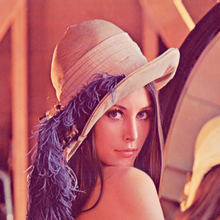

scrambled image:


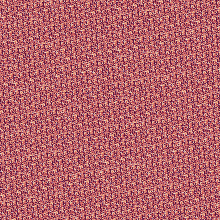

encrypted image:


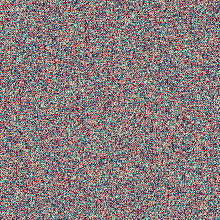

decrypted scrambled image:


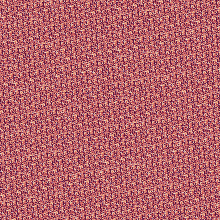

descrambled image:


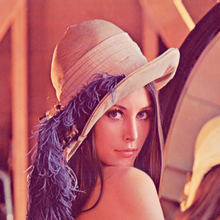

In [73]:
if __name__ == "__main__":
    x_0, lambda_, iterations = 0.3, 1.97, 30
    print(f"Starting Parameters : X_0 = {x_0}, lambda = {lambda_}, Number of iterations = {iterations}")
    path = './Lenna_(test_image).png'
    while not os.path.exists(path):
        path = input("Couldn't find your chosen image, please try again:\n\t")
    with load_pic(path) as image:
        print("original image:")
        display(image)
        dim = width, height = image.size
        chaotic_values = get_all_chaotic_values(x_0, lambda_, max(iterations, width * height))
    result = chaotic_cat_map(path, iterations)
    print("scrambled image:")
    display(result)
    array = np.array(result)
    C, key = encrypt_Image(array)
    encrypted_Image = fromarray(np.uint8(C)).convert('RGB')
    print("encrypted image:")
    display(encrypted_Image)
    img = decrypt_to_scrambled(C, key)
    img = (fromarray(np.uint8(img)).convert('RGB'))
    print("decrypted scrambled image:")
    display(img)
    img = chaotic_cat_map_inverse(img, iterations)
    print("descrambled image:")
    display(img)